In [2]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D, UpSampling2D, Input,Dropout,Conv2DTranspose,Concatenate
from keras.layers import  Conv1D, MaxPooling1D, UpSampling1D,Concatenate, PReLU
from keras import optimizers
from error_measure import *

Using TensorFlow backend.


In [3]:
original_dataset_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\recordings\\"

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"
train_dir = os.path.join(base_dir, 'train\\')

test_dir = os.path.join(base_dir, 'test\\')
train_dir_filtré=os.path.join(base_dir, 'train_dir_filtré\\')
test_dir_filtré=os.path.join(base_dir, 'test_dir_filtré\\')

In [4]:
Xtest,max_test= dir_to_wav_array(test_dir)
Xtrain,max_train= dir_to_wav_array(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [5]:
fce=0.1814#sr=22050
ftype="butter"
ordre=2
b,a = creer_filter(fce,"highpass",ftype,ordre)
filter_path(train_dir,train_dir_filtré,b,a)
filter_path(test_dir,test_dir_filtré,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [6]:
print(Xtest.shape)

(200, 8000, 1, 1)


In [7]:
Xtrain_fil,max_train_fil=dir_to_wav_array(train_dir_filtré)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [8]:
#réseau audio net
input_img = Input(shape=(8000,1,1))

conv1= Conv2D(32, (7, 1), padding='same',strides=1)(input_img)
conv1 = PReLU(shared_axes=[1, 2], name='prelu1')(conv1)
max1= MaxPooling2D((2, 1), padding='same')(conv1)

conv3 = Conv2D(32, (7, 1), padding='same',strides=1)(max1)
conv3 = PReLU(shared_axes=[1, 2], name='prelu3')(conv3)              
encoded = MaxPooling2D((2, 1), padding='same')(conv3)
x = Conv2D(32, (7, 1), padding='same',strides=1)(encoded)
x = PReLU(shared_axes=[1, 2], name='prelu4')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu5')(x)
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu6')(x)

x = UpSampling2D((2, 1))(x)
# merge2=Concatenate(axis=-1)([x,conv3])
x = Conv2D(32, (7, 1), padding='same',strides=1)(x)
x = PReLU(shared_axes=[1, 2], name='prelu8')(x)
# x=Dropout(0.5)(x)
x = UpSampling2D((2, 1))(x)
# merge1=Concatenate(axis=-1)([x,conv1])
decoded = Conv2D(1, (7, 1), padding='same',strides=1)(x)
decoded = PReLU(shared_axes=[1, 2], name='prelu9')(decoded)
# decoded=Dropout(0.5)(decoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8000, 1, 32)       256       
_________________________________________________________________
prelu1 (PReLU)               (None, 8000, 1, 32)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4000, 1, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4000, 1, 32)       7200      
_________________________________________________________________
prelu3 (PReLU)               (None, 4000, 1, 32)       32        
_________________________________________________________________
max_

In [9]:
G=1
history=autoencoder.fit(Xtrain_fil*G,Xtrain*G,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil*G, Xtest*G))

Instructions for updating:
Use tf.cast instead.
Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 182s 101ms/step - loss: 0.0624 - val_loss: 0.0569
Epoch 2/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0624 - val_loss: 0.0569
Epoch 3/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0625 - val_loss: 0.0569
Epoch 4/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0624 - val_loss: 0.0568
Epoch 5/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0624 - val_loss: 0.0568
Epoch 6/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0622 - val_loss: 0.0566
Epoch 7/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0618 - val_loss: 0.0561
Epoch 8/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0613 - val_loss: 0.0559
Epoch 9/40
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0612 - 

In [10]:
# autoencoder.save("audio_network_800Hz_40epochs.h5")

In [11]:
# autoencoder=load_model("audio_network.h5")

In [12]:
decoded = autoencoder.predict(Xtest_fil)

In [13]:
p=15
sr=8000
#indice to display
xtest=np.reshape(Xtest[p],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"0_jackson_0_wav_test.wav")
soundfile.write(audio_path_record_in,xtest*max_test[p],sr)
ipd.Audio(audio_path_record_in)

In [14]:
print(Xtest[p]*max_test[p])

[[[0.00015959]]

 [[0.00010922]]

 [[0.00032732]]

 ...

 [[0.        ]]

 [[0.        ]]

 [[0.        ]]]


In [15]:
print(decoded[p])

[[[-1.0433410e-03]]

 [[-1.9568431e-03]]

 [[-2.4835663e-03]]

 ...

 [[-2.6406276e-05]]

 [[-4.6654532e-05]]

 [[-3.7729702e-04]]]


In [16]:
y=np.reshape(decoded[p],(8000))
bpost,apost=creer_filter(0.005,"highpass","butter",ordre=6)
y_fil=filtrage(bpost,apost,y)
audio_path_record_out=os.path.join(audio_path_record,"0_jackson_0_wav_reconstructed.wav")
soundfile.write(audio_path_record_out,y*max_test[p],sr)
ipd.Audio(audio_path_record_out)

In [17]:
xtest_fil=np.reshape(Xtest_fil[p],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"0_jackson_0_filtered.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[p],sr)
ipd.Audio(audio_path_record_in_fil)

In [18]:
import sklearn
error=sklearn.metrics.mean_squared_error(xtest,y)
print(error)

0.018772194995155457


In [19]:
error_fil=sklearn.metrics.mean_squared_error(xtest,y_fil)
print(error_fil)

0.018740552620344648


(1025, 16)
(1025, 16)
(1025, 16)


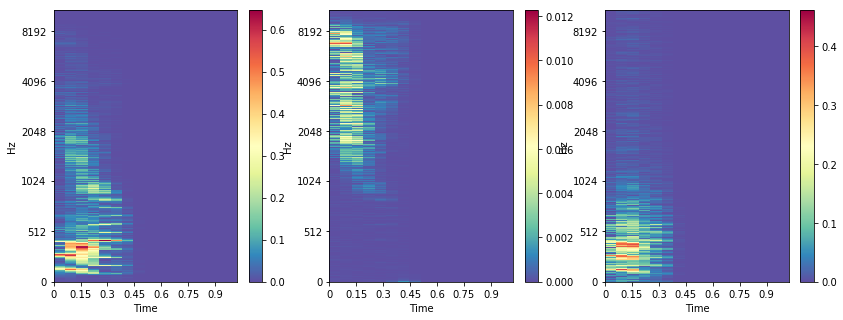

In [20]:
X=librosa.stft(xtest*max_test[p])
Xdec=librosa.stft(y*max_test[p])
Xfil=librosa.stft(xtest_fil*max_test_fil[p])
figure(figsize=(14, 5))
plt.subplot(1,3,1)
Xdb = np.log10(abs(X)+1)
print(Xdb.shape)
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
Xfildb = np.log10(abs(Xfil)+1)
print(Xfildb.shape)
librosa.display.specshow(Xfildb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
Xdecdb = np.log10(abs(Xdec)+1)
print(Xdecdb.shape)
librosa.display.specshow(Xdecdb, sr=sr, x_axis='time', y_axis='mel',cmap='Spectral_r')
colorbar()

In [21]:
error_spec=sklearn.metrics.mean_squared_error(Xdb,Xdecdb)
print(error_spec)

0.0010816898


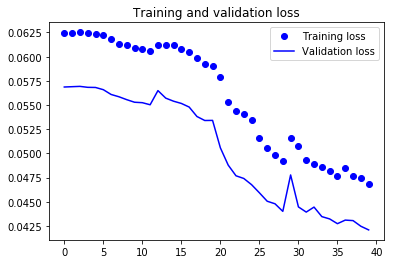

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# mel spectro reconstruction
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtrain_mel,Phase_train=dir_to_log_mel(train_dir)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train\9_theo_28.wav


In [24]:
Xtrain_fil_mel,Phase_train_fil=dir_to_log_mel(train_dir_filtré)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\5_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\7_theo_36.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_16.wav
C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\train_dir_filtré\9_theo_28.wav
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [27]:
input_mel = Input(shape=(1024, 16,1))

conv1= Conv2D(32, (3, 3), activation='relu', padding='same')(input_mel)
max1= MaxPooling2D((2, 1), padding='same')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(max1)
encoded = MaxPooling2D((2, 1), padding='same')(conv2)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 1))(x)



decoded_mel = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
autoencoder_mel = Model(input_mel, decoded_mel)
autoencoder_mel.compile(optimizer=optimizers.Adam(lr=0.001), loss='mae')
#optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
autoencoder_mel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024, 16, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1024, 16, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 512, 16, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 512, 16, 32)       9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 16, 32)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 16, 32)       9248      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 16, 32)       9248      
__________

In [28]:
autoencoder_mel.fit(Xtrain_fil_mel,Xtrain_mel,epochs=40,
                batch_size=20,
                shuffle=True,
                validation_data=(Xtest_fil_mel, Xtest_mel))

Train on 1800 samples, validate on 200 samples
Epoch 1/40
1800/1800 [==============================] - 12s 7ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 2/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 3/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 4/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 5/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 6/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 7/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 8/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 9/40
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0324 - val_loss: 0.0309
Epoch 10/40
1800/1800 [===

In [ ]:
# autoencoder_mel.save("mel_spec_network_800Hz_40epochs.h5")

In [ ]:
# autoencoder_mel=load_model("mel_spec_network.h5")

In [29]:
decoded_mel = autoencoder_mel.predict(Xtest_fil_mel)

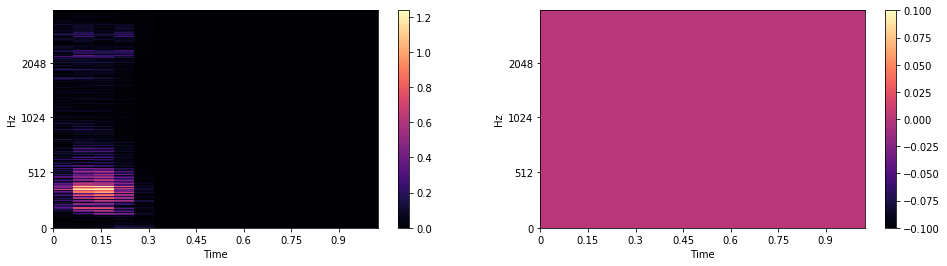

In [30]:
p3=125
Spec_dec=np.reshape(decoded_mel[p3],(decoded_mel.shape[1],decoded_mel.shape[2]))
Spec=np.reshape(Xtest_mel[p3],(Xtest_mel.shape[1],Xtest_mel.shape[2]))
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
librosa.display.specshow(Spec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()
plt.subplot(1,2,2)
librosa.display.specshow(Spec_dec, sr=8000, x_axis='time', y_axis='mel',fmax=4000)
colorbar()

In [31]:
error_spec=sklearn.metrics.mean_squared_error(Spec,Spec_dec)
print(error_spec)

0.011429155838131842


In [32]:
Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
mix_audio=merge_specphase_to_audio(Lin_dec,decoded)

In [33]:
print(mse_audio(Xtest,Xtest_fil))

0.00020871767928965778


In [34]:
print(mse_audio(Xtest,decoded))

8.214905553986016e-05


In [35]:
print(mse_audio(Xtest,mix_audio))

C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\error_measure.py:16: RuntimeWarning: invalid value encountered in true_divide
  error=sklearn.metrics.mean_squared_error(np.reshape(x[i],(x.shape[1]))*1/np.linalg.norm(x[i]),np.reshape(y[i],(y.shape[1]))*1/np.linalg.norm(y[i]))+error


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:

xtest3=np.reshape(Xtest[p3],(8000))
soundfile.write(audio_path_record_in,xtest3*max_test[p3],sr)
ipd.Audio(audio_path_record_in)

In [ ]:
xtest3_fil=np.reshape(Xtest_fil[p3],(8000))
soundfile.write(audio_path_record_in_fil,xtest3_fil*max_test_fil[p3],sr)
ipd.Audio(audio_path_record_in_fil)

In [ ]:

audio_path_record_audio_mix3=os.path.join(audio_path_record,"3_mix.wav")
soundfile.write(audio_path_record_audio_mix3,mix_audio[p3]*2,sr)
ipd.Audio(audio_path_record_audio_mix3)

In [ ]:
y3=np.reshape(decoded[p3],(8000))
audio_path_record_out3=os.path.join(audio_path_record,"3_reconstructed.wav")
soundfile.write(audio_path_record_out3,y3*max_test[p3],sr)
ipd.Audio(audio_path_record_out3)

In [ ]:
from scipy.stats import pearsonr
print(pearsonr(xtest3,y3)[0])

In [ ]:
print(pearsonr(xtest3,mix_audio[p3])[0])

In [ ]:
print(np.linalg.norm(xtest3))

In [ ]:
print(np.linalg.norm(y3))

In [ ]:
print(np.linalg.norm(mix_audio[p3]))

In [ ]:
error3mix=sklearn.metrics.mean_squared_error(xtest3*1/np.linalg.norm(xtest3),mix_audio[p3]*1/np.linalg.norm(mix_audio[p3]))
print(error3mix)

In [ ]:
error3=sklearn.metrics.mean_squared_error(xtest3*1/np.linalg.norm(xtest3),y3*1/np.linalg.norm(y3))
print(error3)

In [ ]:
print(np.correlate(xtest3*1/np.linalg.norm(xtest3),mix_audio[p3]*1/np.linalg.norm(mix_audio[p3])))

In [ ]:
print(np.correlate(xtest3*1/np.linalg.norm(xtest3),y3*1/np.linalg.norm(y3)))

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
plt.plot(xtest3)
title("signal attendu")
plt.subplot(1,3,2)
plt.plot(y3)
title("signal en sortie du réseau audio")
plt.subplot(1,3,3)
plt.plot(mix_audio[p3])
title("signal après mixage mel audio")

In [ ]:
lim_sup=2100
lim_min=2000

plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
plt.plot(xtest3[lim_min:lim_sup],"bo--")
title("signal attendu")
plt.subplot(1,4,2)
plt.plot(y3[lim_min:lim_sup],"bo--")

title("signal en sortie du réseau audio")
plt.subplot(1,4,3)
plt.plot(mix_audio[p3][lim_min:lim_sup],"bo--")
title("signal après mixage mel audio")
plt.subplot(1,4,4)
plt.plot(xtest3[lim_min:lim_sup]*1/np.linalg.norm(xtest3),"bo",label="attendu")
plt.plot(y3[lim_min:lim_sup]*1/np.linalg.norm(y3),"go",label="sortie reseau audio")
plt.plot(mix_audio[p3][lim_min:lim_sup]*1/np.linalg.norm(mix_audio[p3]),"ro",label="mix mel audio")
title("visualisation des 3 sur un meme graphe")
plt.legend()

In [ ]:
print(mse_melSpectro(Xtest_mel,Xtest_fil_mel))

In [ ]:
Spec_decoded=audioarray_to_melspectro(decoded)
print(mse_melSpectro(Xtest_mel,Spec_decoded))

In [ ]:
print(mse_melSpectro(Xtest_mel,decoded_mel))

In [ ]:
p3=125
plt.figure(figsize=(16, 4))
plt.subplot(1,4,1)
librosa.display.specshow(np.reshape(Xtest_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,2)
librosa.display.specshow(np.reshape(Xtest_fil_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,3)
librosa.display.specshow(np.reshape(Spec_decoded[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,4,4)
librosa.display.specshow(np.reshape(decoded_mel[p3],(1024,16)), sr=8000, x_axis='time', y_axis='mel',fmax=4000,cmap='Spectral_r')
colorbar()

In [ ]:
Lin_test_mel=mel_to_linspec(Xtest_mel,sr=8000,n_mels=1024,n_fft=2048)

print(mse_melSpectro(Lin_test_mel,Lin_dec))

In [ ]:
Lin_audio=mel_to_linspec(Spec_decoded,sr=8000,n_mels=1024,n_fft=2048)
print(mse_melSpectro(Lin_test_mel,Lin_audio))

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
librosa.display.specshow(Lin_test_mel[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,2)
librosa.display.specshow(Lin_audio[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()
plt.subplot(1,3,3)
librosa.display.specshow(Lin_dec[p3], sr=8000, x_axis='time', y_axis='log',fmax=4000,cmap='Spectral_r')
colorbar()